# GPT3.5 Fine-tuning Modeling for Software Citation Intent Prediction

In this notebok, we showcase an example of finetuning GPT3.5 for predicting software citation intent.
Note that running this notebook requires access to an OpenAI API key, which can be retrieved from the OpenAI API website: https://openai.com/product#made-for-developers

In [1]:
import pandas as pd
import os
from openai import OpenAI
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
# your OpenAI key goes here
OPENAI_API_KEY = ""
client = OpenAI(api_key = OPENAI_API_KEY)
import warnings
warnings.simplefilter("ignore")
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import plotly.express as px
from collections import Counter
np.random.seed(123)
ROOT_DIR = '../data/'
pred_field = 'sentence'  # this can be one of : 'sentence' or 'context'

## Data Reading + Formatting

In [2]:
data_df = pd.read_csv('../data/software_citation_intent_merged.csv')
LABEL2TEXT = {0: 'creation', 1 : 'usage', 2 : 'mention', 3 : 'none'}
data_df['label_descriptive'] = data_df['label'].apply(lambda x: LABEL2TEXT[x])

In [3]:
data_df.head()

,Unnamed: 0,id,sentence,used,created,mention,context,label,text,label_descriptive
0,0,PMC5189946,All of this analysis was implemented using Mat...,False,True,False,NaN,0,All of this analysis was implemented using Mat...,creation
1,1,PMC4511233,"Code for calculating partition similarity, obt...",False,True,False,Since the probability of getting a given MI is...,0,"Code for calculating partition similarity, obt...",creation
2,2,PMC4186879,All behavioral statistical analyses were perfo...,False,False,True,All behavioral statistical analyses were perfo...,2,All behavioral statistical analyses were perfo...,mention
3,3,PMC5026371,"M-Track was written using Python 2.7, OpenCV 3...",True,False,False,NaN,1,"M-Track was written using Python 2.7, OpenCV 3...",usage
4,4,PMC1283974,"Mindboggle is a freely downloadable, open sour...",False,True,False,"Mindboggle is a freely downloadable, open sour...",0,"Mindboggle is a freely downloadable, open sour...",creation


In [4]:
def update_context(df):
    df['context'] = df.apply(lambda x: x['context'] if x['context'] == x['context'] else x['sentence'], axis = 1)

In [5]:
data_df.head()

,Unnamed: 0,id,sentence,used,created,mention,context,label,text,label_descriptive
0,0,PMC5189946,All of this analysis was implemented using Mat...,False,True,False,NaN,0,All of this analysis was implemented using Mat...,creation
1,1,PMC4511233,"Code for calculating partition similarity, obt...",False,True,False,Since the probability of getting a given MI is...,0,"Code for calculating partition similarity, obt...",creation
2,2,PMC4186879,All behavioral statistical analyses were perfo...,False,False,True,All behavioral statistical analyses were perfo...,2,All behavioral statistical analyses were perfo...,mention
3,3,PMC5026371,"M-Track was written using Python 2.7, OpenCV 3...",True,False,False,NaN,1,"M-Track was written using Python 2.7, OpenCV 3...",usage
4,4,PMC1283974,"Mindboggle is a freely downloadable, open sour...",False,True,False,"Mindboggle is a freely downloadable, open sour...",0,"Mindboggle is a freely downloadable, open sour...",creation


In [6]:
def get_labels(df):
    final_labels = []
    used_labels = df['used'].to_list()
    created_labels = df['created'].to_list()
    mention_labels = df['mention'].to_list()
    sentences = df['sentence'].to_list()

    for used_label, created_label, mention_label, sentence in zip(used_labels, created_labels, mention_labels, sentences):
        final_label = 'no_label'
        if used_label:
            final_label = 'used'
        elif created_label:
            final_label = 'created'
        elif mention_label:
            final_label = 'mentioned'
        num_true = int(used_label) + int(created_label) + int(mention_label)
        if (num_true > 1):
            print(sentence, num_true)
        final_labels.append(final_label)
    return final_labels

In [7]:
X_train_df = pd.read_csv('../data/gpt3.5_formatted_data/gpt3.5_train.csv')
X_test_df = pd.read_csv('../data/gpt3.5_formatted_data/gpt3.5_test.csv')
update_context(X_train_df)
update_context(X_test_df)

labels = get_labels(X_train_df)
X_train_df, X_val_df = train_test_split(X_train_df, test_size=0.2, stratify=labels, random_state=42)

In [8]:
train_sentences = X_train_df[pred_field].to_list()
val_sentences = X_val_df[pred_field].to_list()
test_sentences = X_test_df[pred_field].to_list()

y_train = X_train_df['label_descriptive'].to_list()
y_val = X_val_df['label_descriptive'].to_list()
y_test = X_test_df['label_descriptive'].to_list()

In [9]:
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))
print(len(X_train_df), len(X_val_df), len(X_test_df))

Counter({'usage': 1436, 'none': 640, 'mention': 304, 'creation': 300})
Counter({'usage': 359, 'none': 160, 'mention': 76, 'creation': 75})
Counter({'usage': 449, 'none': 200, 'mention': 95, 'creation': 94})
2680 670 838


Convert to OpenAI fine-tuned format:
```
{"messages": 
  [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, 
  {"role": "user", "content": "What's the capital of France?"}, 
  {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}

{"messages": 
  [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, 
  {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, 
  {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}

{"messages": 
  [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, 
  {"role": "user", "content": "How far is the Moon from Earth?"}, 
  {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}
```

In [10]:
import json
INITIAL_MESSAGE = {"role": "system", 
                "content": "You are a scientist trying to figure out the citation intent behind software mentioned in sentences coming from research articles. Your four categories are: creation, usage, mention, or none. The definitions of the classes are: \
                - creation: software was created by the authors of the paper \
                - usage: software was used in the paper \
                - mention: software was mentioned in the paper, but not used, nor created \
                - none: none of the previous 3 categories apply \
                You need to output one category only."}

jsonl_train = ROOT_DIR + 'gpt3.5-software-citation-intent-train-data.jsonl'
jsonl_val = ROOT_DIR + 'gpt3.5-software-citation-intent-val-data.jsonl'
jsonl_test = ROOT_DIR + 'gpt3.5-software-citation-intent-test-data.jsonl'

def generate_jsonl_file(jsonl_filename, sentences, labels):
        with open(jsonl_filename, mode='w') as f:
                for sentence, label in zip(sentences, labels):
                        message = {"messages" : [INITIAL_MESSAGE, 
                                {'role' : 'user', 'content' : sentence},
                                {'role' : 'assistant', 'content' : label}]}
                        f.write(json.dumps(message) + "\n")

In [11]:
generate_jsonl_file(jsonl_train, train_sentences, y_train)
generate_jsonl_file(jsonl_val, val_sentences, y_val)
generate_jsonl_file(jsonl_test, test_sentences, y_test)

## GPT3.5 Fine-tuning

In [12]:
client.files.create(
  file=open(ROOT_DIR + 'gpt3.5-software-citation-intent-train-data.jsonl', "rb"),
  purpose='fine-tune'
)

FileObject(id='file-G4XP4GR8II5jCJwLdCBy7zSV', bytes=2270720, created_at=1710190761, filename='gpt3.5-software-citation-intent-train-data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [13]:
client.files.create(
  file=open(ROOT_DIR + 'gpt3.5-software-citation-intent-val-data.jsonl', "rb"),
  purpose='fine-tune'
)

FileObject(id='file-4dNzQMITP70VXPW8mqaqhqYw', bytes=566876, created_at=1710190762, filename='gpt3.5-software-citation-intent-val-data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [16]:
# this flag should be set to True if you want to train from scratch
train = True
if train:
    client.fine_tuning.jobs.create(
        training_file="file-G4XP4GR8II5jCJwLdCBy7zSV", 
        validation_file = "file-4dNzQMITP70VXPW8mqaqhqYw", 
        model="gpt-3.5-turbo", 
        hyperparameters = {'n_epochs' : 5}
    )

### Use in inference mode

In [17]:
def get_gpt_predicted_labels(test_sentences, has_true_labels, model_name, true_labels = []):
  predicted_labels = []
  true_labels_completed = []
  completed_sentences = []
  for i, sentence in enumerate(test_sentences):
    print('Sentence', i)
    try:
      completion = client.chat.completions.create(
        model=model_name,
        messages=[
          INITIAL_MESSAGE,
          {"role": "user", "content": sentence} 
        ]
      )
      predicted_label = completion.choices[0].message.content
      predicted_labels.append(predicted_label)
      completed_sentences.append(sentence)
      if has_true_labels:
        true_labels_completed.append(true_labels[i])
    except:
      print('oops got an error')
      i -= 1
      continue
  return predicted_labels, true_labels_completed, completed_sentences

### Test dataset

In [18]:
def evaluate(true_labels, predicted_labels):
    p, r, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, average='macro', labels = list(LABEL2TEXT.values()))
    accuracy = round(accuracy_score(true_labels, predicted_labels), 3)
    print('Precision: ', round(p, 3), 'Recall: ', round(r, 3), 'F1:', round(f1, 3), 'Accuracy:', accuracy)
    print(classification_report(true_labels, predicted_labels, labels = list(LABEL2TEXT.values())))

In [19]:
finetuned_model_name = "ft:gpt-3.5-turbo-0125:personal::91iJLEAz"
y_pred_completed, y_true_completed, test_completed_sentences = get_gpt_predicted_labels(test_sentences, True, finetuned_model_name, y_test)
evaluate(y_pred_completed, y_true_completed)

Sentence 0
Sentence 1
Sentence 2
Sentence 3
Sentence 4
Sentence 5
Sentence 6
Sentence 7
Sentence 8
Sentence 9
Sentence 10
Sentence 11
Sentence 12
Sentence 13
Sentence 14
Sentence 15
Sentence 16
Sentence 17
Sentence 18
Sentence 19
Sentence 20
Sentence 21
Sentence 22
Sentence 23
Sentence 24
Sentence 25
Sentence 26
Sentence 27
Sentence 28
Sentence 29
Sentence 30
Sentence 31
Sentence 32
Sentence 33
Sentence 34
Sentence 35
Sentence 36
Sentence 37
Sentence 38
Sentence 39
Sentence 40
Sentence 41
Sentence 42
Sentence 43
Sentence 44
Sentence 45
Sentence 46
Sentence 47
Sentence 48
Sentence 49
Sentence 50
Sentence 51
Sentence 52
Sentence 53
Sentence 54
Sentence 55
Sentence 56
Sentence 57
Sentence 58
Sentence 59
Sentence 60
Sentence 61
Sentence 62
Sentence 63
Sentence 64
Sentence 65
Sentence 66
Sentence 67
Sentence 68
Sentence 69
Sentence 70
Sentence 71
Sentence 72
Sentence 73
Sentence 74
Sentence 75
Sentence 76
Sentence 77
Sentence 78
Sentence 79
Sentence 80
Sentence 81
Sentence 82
Sentence 83
Se

In [20]:
evaluate(y_true_completed, y_pred_completed)

Precision:  0.839 Recall:  0.867 F1: 0.851 Accuracy: 0.9
              precision    recall  f1-score   support

    creation       0.80      0.91      0.85        94
       usage       0.97      0.93      0.95       449
     mention       0.65      0.69      0.67        95
        none       0.94      0.93      0.94       200

   micro avg       0.90      0.90      0.90       838
   macro avg       0.84      0.87      0.85       838
weighted avg       0.91      0.90      0.90       838



In [21]:
X_test_df

,Unnamed: 0,id,sentence,used,created,mention,context,label,text,label_descriptive
0,1513,PMC5513414,Statistical analyses were performed in STATA (...,True,False,False,Robust standard errors were computed in all mo...,1,Statistical analyses were performed in STATA (...,usage
1,2097,PMC2790482,Reconstructed images were further processed us...,True,False,False,The images of each retina were saved in a fold...,1,Reconstructed images were further processed us...,usage
2,544,PMC6016926,Participants who self-reported attacks by S. i...,False,False,False,Participants who self-reported attacks by S. i...,3,Participants who self-reported attacks by S. i...,none
3,413,PMC4887034,The mean waveform shape of each unit was ident...,True,False,False,"Open sorter (Tucker Davis Technologies, FL, US...",1,The mean waveform shape of each unit was ident...,usage
4,1768,PMC5967744,"As the name already indicates, the random effe...",True,False,False,"Beta(r,s). As the name already indicates, the ...",1,"As the name already indicates, the random effe...",usage
...,...,...,...,...,...,...,...,...,...,...
833,2510,PMC4154637,"With Pep2Path, we introduce a software package...",False,True,False,Even though mass-spectrometric peptide detecti...,0,"With Pep2Path, we introduce a software package...",creation
834,1704,PMC5289551,Statistical analysis was undertaken using the ...,True,False,False,Statistical analysis was undertaken using the ...,1,Statistical analysis was undertaken using the ...,usage
835,2317,a7a83e8d-97c9-43ed-8e51-50de779d973d,"In the present work, we describe an overall ma...",True,False,False,Rather high precision and low rate of false po...,1,"In the present work, we describe an overall ma...",usage
836,3204,d9bfdd46-f9ed-4282-a52f-369a7eb0ab00,"To date, PlayMOBY handles more than 100 BioMOB...",False,False,True,"Thus, PlayMOBY reduces the overheads of publis...",2,"To date, PlayMOBY handles more than 100 BioMOB...",mention


In [22]:
def get_pred_label(x, completed_sentences, y_pred_completed):
    for sent, label in zip(completed_sentences, y_pred_completed):
        if sent == x:
            if label in LABEL2TEXT.values():
                return label
            else:
                return 'none'
    return 'no_prediction'

# X_test_df['label'] = X_test_df['label'].apply(lambda x: LABEL2TEXT[x])
X_test_df['category'] = 'true'
X_test_df['pred_label'] = X_test_df['text'].apply(lambda x: get_pred_label(x, test_completed_sentences, y_pred_completed))
X_test_df_pred = X_test_df.copy()
X_test_df_pred['category'] = 'pred_gpt3.5'

X_test_df_pred['label'] = X_test_df_pred['text'].apply(lambda x: get_pred_label(x, test_completed_sentences, y_pred_completed))
X_test_df_all = pd.concat([X_test_df_pred, X_test_df])

### CZI validation dataset

In [27]:
czi_val_df = pd.read_csv('../data/czi_val_merged.csv').drop_duplicates()
czi_val_df['label'] = czi_val_df['label'].apply(lambda x: 'mention' if x == 'none' else x)
test_sentences_czi = czi_val_df['text'].to_list()
y_test_czi = czi_val_df['label'].to_list()
y_pred_czi_completed, y_true_czi_completed, completed_sentences = get_gpt_predicted_labels(test_sentences_czi, True, finetuned_model_name, y_test_czi)

Sentence 0
Sentence 1
Sentence 2
Sentence 3
Sentence 4
Sentence 5
Sentence 6
Sentence 7
Sentence 8
Sentence 9
Sentence 10
Sentence 11
Sentence 12
Sentence 13
Sentence 14
Sentence 15
Sentence 16
Sentence 17
Sentence 18
Sentence 19
Sentence 20
Sentence 21
Sentence 22
Sentence 23
Sentence 24
Sentence 25
Sentence 26
Sentence 27
Sentence 28
Sentence 29
Sentence 30
Sentence 31
Sentence 32
Sentence 33
Sentence 34
Sentence 35
Sentence 36
Sentence 37
Sentence 38
Sentence 39
Sentence 40
Sentence 41
Sentence 42
Sentence 43
Sentence 44
Sentence 45
Sentence 46
Sentence 47
Sentence 48
Sentence 49
Sentence 50
Sentence 51
Sentence 52
Sentence 53
Sentence 54
Sentence 55
Sentence 56
Sentence 57
Sentence 58
Sentence 59
Sentence 60
Sentence 61
Sentence 62
Sentence 63
Sentence 64
Sentence 65
Sentence 66
Sentence 67
Sentence 68
Sentence 69
Sentence 70
Sentence 71
Sentence 72
Sentence 73
Sentence 74
Sentence 75
Sentence 76
Sentence 77
Sentence 78
Sentence 79
Sentence 80
Sentence 81
Sentence 82
Sentence 83
Se

In [28]:
czi_val_df.head()

,doi_link,source,text,software,intent,label
0,https://doi.org/10.1371/journal.pone.0043845,10. Confocal microscopy,Confocal laser scanning was performed on a Oly...,Fluoview,used,usage
1,https://doi.org/10.1155/2014/395212,5. Simulation Results and Analysis,"In Figure 11, p miss of SVM-SMP is nearly equa...",SVM,used,usage
2,https://doi.org/10.3389/fphys.2020.587057,Network Architecture and Training Parameters,A pattern recognition network was created usin...,MATLAB,used,usage
3,https://doi.org/10.1186/s13046-018-0997-7,paper_abstract,"Finally, we investigated the potential molecul...",analysis (GSEA),used,usage
4,https://doi.org/10.7717/peerj.9470,Conclusions,The GitHub repository for this study has been ...,Python,used,usage


In [29]:
czi_val_df['category'] = 'true'
czi_val_df['pred_label'] = czi_val_df['text'].apply(lambda x: get_pred_label(x, completed_sentences, y_pred_czi_completed))
czi_val_df_pred = czi_val_df.copy()
czi_val_df_pred['category'] = 'pred_gpt3.5'

czi_val_df_pred['label'] = czi_val_df_pred['text'].apply(lambda x: get_pred_label(x, completed_sentences, y_pred_czi_completed))
czi_val_df_all = pd.concat([czi_val_df_pred, czi_val_df])

In [30]:
czi_val_df.groupby('intent').count()

,doi_link,source,text,software,label,category,pred_label
intent,,,,,,,
creation,10,10,10,10,10,10,10
mention,14,14,14,14,14,14,14
used,177,166,177,177,177,177,177


In [31]:
evaluate(y_true_czi_completed, y_pred_czi_completed)

Precision:  0.571 Recall:  0.531 F1: 0.545 Accuracy: 0.881
              precision    recall  f1-score   support

    creation       0.71      0.50      0.59        10
       usage       0.98      0.93      0.95       177
     mention       0.59      0.70      0.64        23
        none       0.00      0.00      0.00         0

    accuracy                           0.88       210
   macro avg       0.57      0.53      0.54       210
weighted avg       0.92      0.88      0.90       210



### Errors

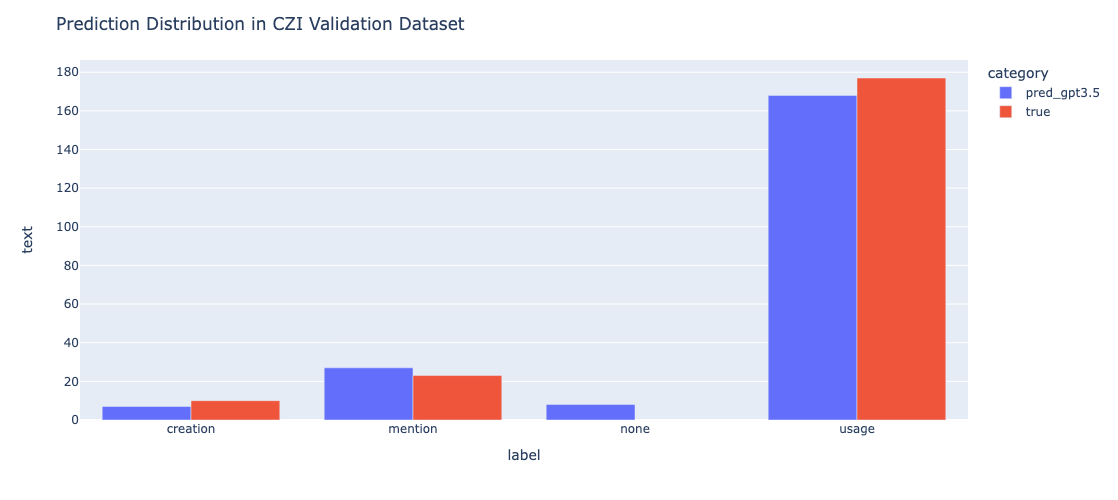

In [32]:
labels_grouped = czi_val_df_all.groupby(['label', 'category']).count().reset_index()
fig = px.bar(labels_grouped, x = 'label', y = 'text', color = 'category', barmode = 'group')
fig.update_layout(width=700,height=500, title = 'Prediction Distribution in CZI Validation Dataset')

#### False negatives

In [33]:
pd.set_option('display.max_colwidth', 1000)
czi_val_df[(czi_val_df['label'] == 'mention') & (czi_val_df['pred_label'] != 'mention')]

,doi_link,source,text,software,intent,label,category,pred_label
39,https://doi.org/10.1107/S1600536809055044,NaN,"Absorption correction: multi-scan (SADABS; Sheldrick, 1996 ▶) T min = 0.66, T max = 0.87",SADABS,NaN,mention,true,usage
70,https://doi.org/10.3390/ijms21020543,3.2. QTL for GY and Secondary Traits under Optimum and Low-N Conditions,Identifying major effect QTL underlying single or multiple traits in various populations determines the successful use of QTL through MAS [8],MAS,mention,mention,true,none
89,https://doi.org/10.3390/diagnostics10010044,2.2. Deep Learning-Based Techniques,"Very recently, one research group applied Mask R-CNN on cervix segmentation tasks, the obtained (Dice, IoU) score is (0.8711, 0.765) on “Kaggle Dataset” as reported in [26]",Mask R-CNN,mention,mention,true,usage
93,https://doi.org/10.1107/S1600536808008076,NaN,"Absorption correction: multi-scan (SADABS; Sheldrick, 1996 ▶) T min = 0.971, T max = 0.972",SADABS,NaN,mention,true,usage
147,https://doi.org/10.1371/journal.pgen.1002902,"Microarray Hybridization, Scanning, Normalization, And Annotation",The Affymetrix GCOS operating system controls the scanner and data acquisition functions,Affymetrix GCOS,mention,mention,true,usage
182,https://doi.org/10.1186/1471-2458-11-S3-S32,Calculating the effects of intermediate health outcomes on mortality,Within LiST however the risks for mortality vis-à-vis stunting are defined in terms of the following four bands on the international normal distribution for height for age:,LiST,mention,mention,true,none
189,https://doi.org/10.1371/journal.pcbi.0030100,Dynamic causal modelling.,"DCM, therefore, can also be regarded as more general, with the general linear model analysis being a specific situation in which the interaction parameters (first and second sets) are assumed to be zero.",DCM,mention,mention,true,none


#### False positives

In [34]:
czi_val_df[(czi_val_df['label'] != 'mention') & (czi_val_df['pred_label'] == 'mention')]

,doi_link,source,text,software,intent,label,category,pred_label
7,https://doi.org/10.1107/S2059798320008049,Use of spherical fragment generation for structure determination,"This in turn will require improved algorithms, implemented in SHELXE, that take into account the unique aspects of electron scattering.",SHELXE,used,usage,true,mention
34,https://doi.org/10.2196/jmir.5976,Limitations,"However, we are planning research to evaluate the infographics on the actual CHART platform, which would provide personalized assessments and would also enable us to study the effects of infographics on intentions and outcomes related to behavior change.",CHART,used,usage,true,mention
35,https://doi.org/10.1111/jpi.12673,Implementation details,The website is written in the Python programming language using the ‘Flask’ framework,Flask,used,usage,true,mention
46,https://doi.org/10.3389/fpsyt.2021.682952,Data Analysis,Analyses were conducted using R version 4.0.3 (17),R,used,usage,true,mention
154,https://doi.org/10.3390/s21165463,2.3. Positioning Stage,"The LabVIEW-based software was used to define the scanning parameters (area to scan, frequency sweep configuration…) and load them into the Arduino board",LabVIEW,used,usage,true,mention
172,https://doi.org/10.1186/s12918-017-0427-z,Flux Variability Analysis (FVA),FVA can be set up in COBRA toolbox using the function fluxVariability(),COBRA,used,usage,true,mention
401,https://joss.theoj.org/papers/10.21105/joss.05420,title,libscientific: A Powerful C Library for Multivariate Analysis,libscientific,creation,creation,true,mention
406,https://joss.theoj.org/papers/10.21105/joss.05313,title,QuaC: A Pipeline Implementing Quality Control Best Practices for Genome Sequencing and Exome Sequencing Data,QuaC,creation,creation,true,mention
407,https://joss.theoj.org/papers/10.21105/joss.05251,title,ReSurfEMG: A Python library for preprocessing and analysis of respiratory EMG.,ReSurfEMG,creation,creation,true,mention
408,https://joss.theoj.org/papers/10.21105/joss.05562,title,DARTS: The Data Analysis Remote Treatment Service,DARTS,creation,creation,true,mention


In [35]:
czi_val_df[(czi_val_df['label'] == 'mention') & (czi_val_df['pred_label'] == 'mention')]

,doi_link,source,text,software,intent,label,category,pred_label
24,https://doi.org/10.1038/s41598-021-87261-4,NaN,"ROI region of interest, STD standard deviation, w/o ROI detection landmark prediction without ROI detection, Mask R-CNN end-to-end model for ROI detection and landmark prediction with Mask R-CNN, w/ ROI detection (segmentation/fixed size or segmentation/variable size or regression /variable size) Landmark prediction with ROI detection of fixed or variable size.",Mask R-CNN,NaN,mention,true,mention
36,https://doi.org/10.1371/journal.pone.0255167,NaN,pyProGA - A PyMOL plugin for protein residue network analysis,PyMOL,NaN,mention,true,mention
40,https://doi.org/10.1002/jrsm.1408,RECOMMENDATIONS,Editors of journals that focus on meta‐analyses could also consider making statcheck a standard part of their peer review process (following the journals Psychological Science and the Journal of Experimental Social Psychology).,statcheck,mention,mention,true,mention
58,https://doi.org/10.3390/s21093079,4.4. Model Analysis & Remarks,"Other solution can be found using other models, such as Dynamic Neural Networks [32], that achieved a 10% margin of error for irrigation scheduling based on soil moisture sensors, and [33], that schedule irrigation based on soil moisture predictions using XGBoost, with a 13% margin of error",XGBoost,mention,mention,true,mention
68,https://doi.org/10.1186/s12870-018-1423-1,NaN,R scripts,R,NaN,mention,true,mention
123,https://doi.org/10.3390/ijerph18052538,2.6. Analysis Strategy,R: A language and environment for statistical computing,R,NaN,mention,true,mention
125,https://doi.org/10.1186/1751-0473-6-13,Sequence Comparison Methods,"This is most often done using heuristics found in utilities such as CLUSTAL W [18], MUSCLE [19], T-COFFEE [20], and ProbCons [21]",T-COFFEE,mention,mention,true,mention
129,https://doi.org/10.1186/1471-2180-11-77,Recombination,"The six methods are: RDP [47], GENECONV [48], Bootscan [49], MaxChi [50], Chimaera [51], and SiScan [52]",GENECONV,NaN,mention,true,mention
130,https://doi.org/10.1186/1471-2105-7-331,Data retrieval and integration,"Data import from flat files is predominantly based on BioJava [24] which is used to parse multi-FASTA, EMBL [25], Genbank [12], and UniProt [11] formats",BioJava,mention,mention,true,mention
133,https://doi.org/10.1371/journal.pone.0075750,Evolutionary conservation analysis of lncRNAs,The PhastCons program uses genome alignments across 30 vertebrate species (30-way) to identify conserved genomic regions based upon a phylogenetic hidden Markov model [97].,PhastCons,mention,mention,true,mention


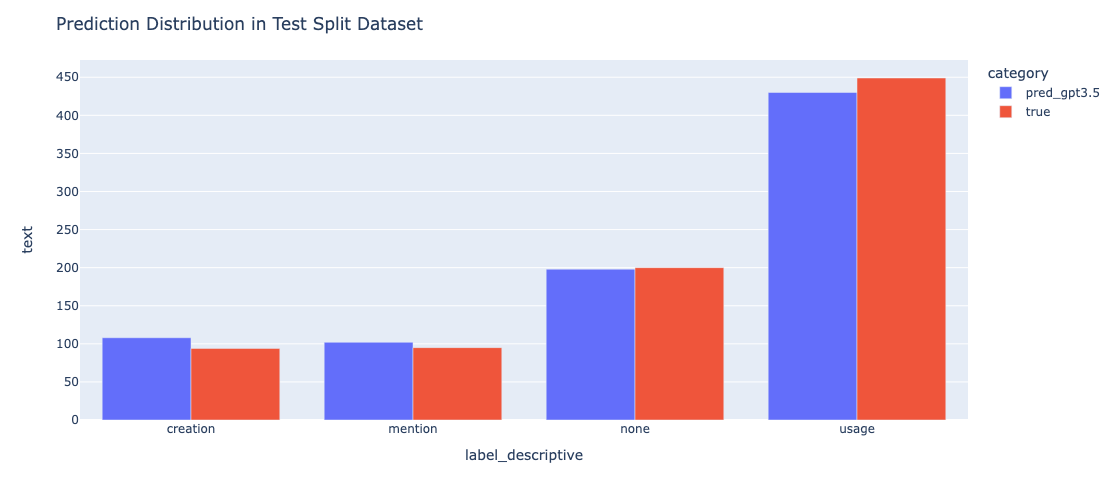

In [36]:
X_test_df['category'] = 'true'
X_test_df['pred_label'] = X_test_df['text'].apply(lambda x: get_pred_label(x, test_completed_sentences, y_pred_completed))
X_test_df_pred = X_test_df.copy()
X_test_df_pred['category'] = 'pred_gpt3.5'
X_test_df_pred['label_descriptive'] = X_test_df_pred['pred_label']

X_test_df_all = pd.concat([X_test_df_pred, X_test_df])

labels_grouped = X_test_df_all.groupby(['label_descriptive', 'category']).count().reset_index()
fig = px.bar(labels_grouped, x = 'label_descriptive', y = 'text', color = 'category', barmode = 'group')
fig.update_layout(width=800,height=500, title = 'Prediction Distribution in Test Split Dataset')